**MLP : метод обратного распространения ошибки**

два обрабатывающих слоя,  
потеря MSQE,  
активация сигмоид

стохастический градиентный спуск SGD

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split

---

In [2]:
# размер скрытого слоя
s_layer = 10

In [3]:
# загружаем даные
data = [ np.vstack([
            np.loadtxt('../data/399_4/points_b.txt'),
            np.loadtxt('../data/399_4/points_g.txt'),
            np.loadtxt('../data/399_4/points_r.txt')
        ]),
        np.loadtxt('../data/399_4/points_y.txt') 
]

In [4]:
# собираем вместе
X = np.vstack(data)

# метки классов
# [-1,1] для выходной активации sigmoid
y = [ [i]*data[i].shape[0] for i in range(len(data)) ]
y = np.asarray(sum(y,[])).reshape(X.shape[0],1)
y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y)
y = y*2-1
X.shape, y.shape

((399, 2), (399, 2))

In [5]:
%xdel data

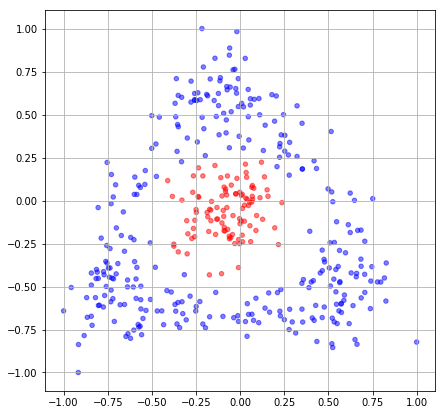

In [6]:
# нормируем данные
X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

plt.figure(figsize=(7,7))
plt.scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(j[0]>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
plt.grid()
plt.show()

---

In [7]:
# ф-ция активации слоёв
def act(z): return np.tanh(z)

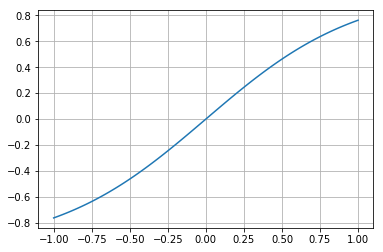

In [8]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act(jj) )
plt.grid()
plt.show()

In [9]:
# производная ф-ции активации слоёв
def act_drv(z): return 1.0/(np.cosh(z)**2)

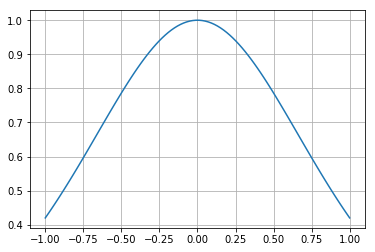

In [10]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act_drv(jj) )
plt.grid()
plt.show()

In [11]:
# MSQE
def loss(o,y):
    e = (o-y).flatten() # ошибки примеров
    e = np.asscalar( e.T.dot(e) )*(1.0/y.shape[0])  # средняя квадратичная ошибка
    assert ~np.isnan(e), 'ошибка вычислений'
    return e

---

In [12]:
# выход
def run(x): 
    return act( act( x.dot(W0) + S0 ).dot(W1) + S1 ) # выход сети


In [13]:
# прямой проход
def forward(x):
    L = [ x.dot(W0) + S0 ] # состояние (не активированное) скрытого слоя
    L.append( act(L[0]).dot(W1) + S1   ) # состояние (не активированное) выходного слоя
    return L


In [14]:
# обратный проход
def backward(L,y):
    O = act(L[1]) # выход сети
    E = [ (O-y)*act_drv(L[1]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W1.T)*act_drv(L[0]) ) # ошибка скрытого слоя
    return E


In [15]:
# градиент
def grad(L,E,x):
    GW = [ x.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O = act(L[0]) # выход скрытого слоя
    GW.append( O.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS

In [16]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), gw[1].flatten(), gs[0], gs[1], ])).max()
        
    if mw != 0.0:
        gw[0] /= mw
        gw[1] /= mw
        gs[0] /= mw
        gs[1] /= mw
    
    return gw,gs


---

In [17]:
# инициализация весов и сдвигов
W0 = np.random.normal(loc=0.0, scale=0.1, size=[X.shape[1],s_layer])
S0 = np.zeros(s_layer)

W1 = np.random.normal(loc=0.0, scale=0.1, size=[s_layer,y.shape[1] ])
S1 = np.zeros(y.shape[1])

In [18]:
# метод градиентного спуска, стохастическая стратегия
a=0.1 # скорость обучения

ex_count = X.shape[0]   # количество примеров
MAX_ITER = 150 # максимальное число циклов обучен
MIN_ERROR = 0.22 # порог минимальной ошибки

err =[1e7] 

f_stop = False

In [19]:
for i in range(MAX_ITER):
    r_idx = np.random.permutation(ex_count) # случайный порядок примеров

    for j in r_idx:
        
        O = run(X) # выход сети
        err.append( loss(O,y) ) # история значений ф-ции потери
        if err[-1] < MIN_ERROR: # проверяем достижение порога ошибки (ф-ции потери)
            f_stop = True
            break
        
        de = err[-1] - err[-2] # изменение ошибки
        if ( de > 0.0 ):  # если ошибка выросла...
            p=1.0/(1.0+np.exp(-de)) 
            if(np.random.rand() < p): # ...то возврат старого состояния с вероятностью p
                W0,S0,W1,S1 = W0p,S0p,W1p,S1p 
                err = err[:-1]
                # print('epoch:',i+1,'rollback')
                
        # выбираем пример        
        xj=X[j,:].reshape(1,X.shape[1])
        yj=y[j,:].reshape(1,y.shape[1])
        
        L=forward(xj) # прямой проход
        E=backward(L,yj) # обратный проход
        GW,GS = grad(L,E,xj) # градиент
        GW,GS = grad_norm(GW,GS) # нормируем градиент

        # сохраняем старые веса
        W0p,S0p,W1p,S1p = W0,S0,W1,S1
        
        # изменяем веса и сдвиги
        W0 = W0 - a*GW[0]
        W1 = W1 - a*GW[1]
        S0 = S0 - a*GS[0]
        S1 = S1 - a*GS[1]
        
#     print('epoch:',i+1,'/',MAX_ITER, 'error:',err[-1],'/',MIN_ERROR)
    
    if (f_stop):  break
        
print('step:',i,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)   

epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 rollback
epoch: 1 r

epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 8 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 rollback
epoch: 9 r

epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 15 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 rollback
epoch: 16 ro

epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 20 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 rollback
epoch: 21 ro

epoch: 27 rollback
epoch: 27 rollback
epoch: 27 rollback
epoch: 27 rollback
epoch: 27 rollback
epoch: 27 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 28 rollback
epoch: 29 rollback
epoch: 29 rollback
epoch: 29 rollback
epoch: 29 rollback
epoch: 29 rollback
epoch: 29 ro

epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 38 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 rollback
epoch: 39 ro

epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 49 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 rollback
epoch: 50 ro

epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 60 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 rollback
epoch: 61 ro

epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 71 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 rollback
epoch: 72 ro

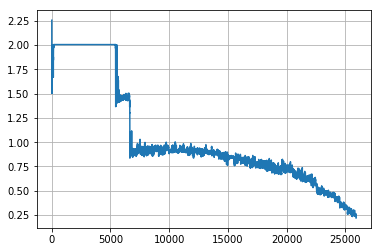

In [20]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[2:])
plt.grid()
plt.show()

---

In [21]:
# результат
O = run(X)
print(loss(O,y))

0.21987797929316513


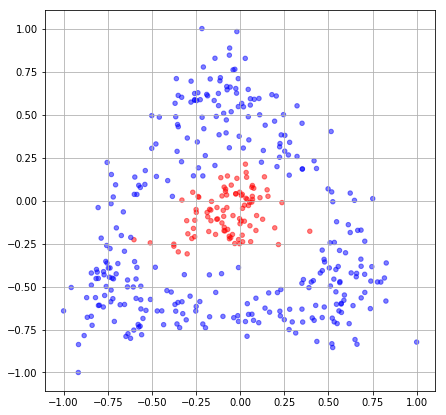

In [22]:
r=np.argmax(O,axis=1).astype(bool)

plt.figure(figsize=(7,7))
plt.scatter( x=X[:,0], 
             y=X[:,1], 
             c=[ 'b' if(~j) else 'r' for j in r ], 
             s=20,
             alpha=0.5 )
plt.grid()
plt.show()